In [1]:
# %pip install numpy==1.24
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # 디버그 메시지 끄기

import tensorflow as tf
print("tensorflow : ", tf.__version__)
gpus = tf.config.experimental.list_physical_devices("GPU")
print("gpus : ", gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
        
# import torch
from matplotlib import pyplot as plt
import cv2

import deeplabcut
import numpy as np

from tqdm.auto import tqdm
import yaml
import angle_out as angle
from data_sensor import analyze_frames, get_img_coord

# yolo_model = torch.hub.load("ultralytics/yolov5", "yolov5l")
# 동영상을 입력으로하며, 학습된 모델을 이용하여 프레임 단위로 분석하고 예측한 관절 좌표를 생성 및 저장한다.

# 이거 필요 없음
"""
----- param -----
src_file_path : 분석할 동영상 파일
config_path : 학습된 모델의 yaml 파일 = dlc_cfg
cfg_path : DLC 프로젝트의 yaml 파일 = cfg
----- pose_cfg.yaml에 추가 -----

init_weights: "/drive/samba/private_files/jupyter/DLC/dog1/dlc-models/iteration-0/dog1Mar24-trainset95shuffle1/train/snapshot-30000"
mean_pixel: [123.68, 116.779, 103.939]
weight_decay: 0.0001
pairwise_predict: False
partaffinityfield_predict: False
stride: 8.0
intermediate_supervision: False
dataset_type: imgaug
"""


""" edit. 폴더명 파라미터로 받아서 실행하기
"""

with open("_mina/project/preLabeled_type(Maltese__Bichon Frise__Poodle)-test01-2023-09-09/config.yaml") as f:
    conf_yaml = yaml.load(f, Loader=yaml.FullLoader)

    # print(conf_yaml["bodyparts"])
    body_parts = []
    for part in conf_yaml["bodyparts"]:
        body_parts.append(part)


frontRightView = ["RightWrist", "RightArm", "Nose"]
frontLeftView = ["LeftWrist", "LeftArm", "Nose"]
backRightView = ["TailTip", "RightFemur", "RightAnkle"]
backLeftView = ["TailTip", "LeftFemur", "LeftAnkle"]
frontRightTilt = ["Neck", "RightWrist", "TailStart"]
frontLeftTilt = ["Neck", "LeftWrist", "TailStart"]
backRightTilt = ["Neck", "TailStart", "RightAnkle"]
backLeftTilt = ["Neck", "TailStart", "LeftAnkle"]
frontRight = ["Neck", "RightArm", "RightWrist"]
frontLeft = ["Neck", "LeftArm", "LeftWrist"]
backRight = ["TailStart", "RightFemur", "RightAnkle"]
backLeft = ["TailStart", "LeftFemur", "LeftAnkle"]
frontBody = ["Nose", "Neck", "TailStart"]
backBody = ["Neck", "TailStart", "TailTip"]
mouth = ["Nose", "MouthCorner", "LowerLip"]
head = ["Nose", "Forehead", "Neck"]
tail = ["TailTip", "TailStart", "LeftAnkle"] or ["TailTip", "TailStart", "RightAnkle"]
direction = ["Nose", "RightArm", "RightFemur"] or ["Nose", "LeftArm", "LeftFemur"]
label_parts = [
    frontRightView,
    frontLeftView,
    backRightView,
    backLeftView,
    frontRightTilt,
    frontLeftTilt,
    backRightTilt,
    backLeftTilt,
    frontRight,
    frontLeft,
    backRight,
    backLeft,
    frontBody,
    backBody,
    mouth,
    head,
    tail,
    direction,
]


tensorflow :  2.11.0
gpus :  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loading DLC 2.3.5...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


/home/pieroot/miniconda3/envs/yolo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pieroot/.local/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


초기화 중...


: 

: 

(640, 960, 3)


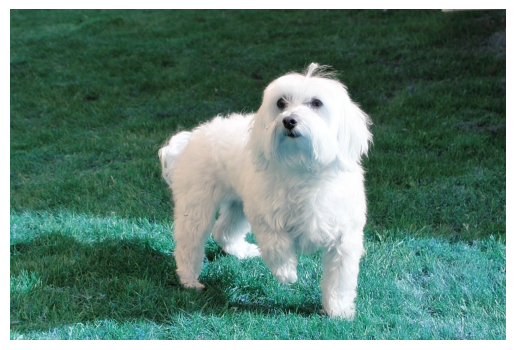

TypeError: 'NoneType' object cannot be interpreted as an integer

In [ ]:
img_path = 'https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbwUfBG%2FbtrqNf6yZb8%2FM0NZrbzkxQa8tNvw6JGtfK%2Fimg.jpg'
import numpy as np
from matplotlib import pyplot as plt
import cv2
import urllib.request

resp = urllib.request.urlopen(img_path)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

# img = cv2.imread(img_path)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(image)
print(image.shape)
plt.show()

data = get_img_coord(image)
print(data)

In [2]:
import natsort
import os
from tqdm.auto import tqdm, trange


def analyze_video(src=None, out="out"):
    # src = videos/WALKRUN_video/dog-walkrun-099432.mp4
    label_ = src.split("_")[0].split("/")[-1]
    # label_ = WALKRUN
    out_postfix = src.split("/")[-1].split(".")[0]
    # out_postfix = dog-walkrun-099432
    des_out = f"{out}/{label_}/{out_postfix}"
    # des_out = ./label1/WALKRUN/dog-walkrun-099432
    os.makedirs(f"{out}/{label_}", exist_ok=True)

    data = analyze_frames(src, 10)
    # print(data.shape[0])
    label = [label_ for i in range(data.shape[0])]

    np.save(f"{des_out}.npy", data)
    with open(f"{des_out}.csv", "w") as f:
        f.write(f"{label}\n")
    return data, label


path = "_mina/project/preLabeled_type(Maltese__Bichon Frise__Poodle)-test01-2023-09-09/videos/20201117_dog-walkrun-002943.mp4.avi"

# for label_dir in natsort.natsorted(os.listdir(path)):
#     video_dir = f"{path}/{label_dir}"
#     if os.path.isdir(video_dir) == False:
#         continue
#     label = label_dir.split("_")[0]
#     # print(f"{video_dir} | {label}")
#     video_list = natsort.natsorted(os.listdir(video_dir))
#     for video in tqdm(video_list, desc=f"Label > {label}", leave=True):
#         # print(f"{video_dir}/{video} | {label}")
#         analyze_video(src=f"{video_dir}/{video}", out="label")
analyze_video(src="",out="")

Label > BODYLOWER:   0%|          | 2/800 [00:16<1:44:01,  7.82s/it]

In [ ]:
import natsort
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from data_sensor import analyze_frame

data = analyze_frame("videos2/kakaotalk_1679886104324.mp4")

In [ ]:
p_data = pd.DataFrame()
for i in range(len(data)):
    p_data[f"{i}_x"] = data[i][:, 0]
    p_data[f"{i}_y"] = data[i][:, 1]
    p_data[f"{i}_likelihood"] = data[i][:, 2]
p_data.to_csv("test.csv", index=False)

In [ ]:
p_data = pd.read_csv("test.csv")
index = 0
for i in p_data.iloc[0]:
    if index % 3 == 2:
        print(i)
    # print(i)
    index += 1
p_data

In [ ]:
def analyze_video(src=None, out="out"):
    # src = videos/WALKRUN_video/dog-walkrun-099432.mp4
    # label_ = src.split("_")[0].split("/")[-1]
    # label_ = WALKRUN
    # out_postfix = src.split("/")[-1].split(".")[0]
    # out_postfix = dog-walkrun-099432
    # des_out = f"{out}/{label_}/{out_postfix}"
    # des_out = ./label1/WALKRUN/dog-walkrun-099432
    # os.makedirs(f"{out}/{label_}", exist_ok=True)

    data = analyze_frames(src, 10)
    # print(data.shape[0])
    label = [label_ for i in range(data.shape[0])]

    # np.save(f"{des_out}.npy", data)
    # with open(f"{des_out}.csv", "w") as f:
        # f.write(f"{label}\n")
    return data, label

In [ ]:
analyze_video(
    src="videos/BODYLOWER_video/20201024_dog-bodylower-000061.mp4.mp4", out="label"
)

In [ ]:
# # analyze_video(src ='./data/' + i + j1 , out='./label/' + i+'/' + j1)
# data_path = './data'
# label_path = './label2'
# for i in os.listdir(data_path):
#     if os.path.isdir(f'{data_path}/{i}') == False:
#         continue
#     if not os.path.exists(f'{label_path}/{i}'):
#         os.makedirs(f'{label_path}/{i}')  # label 폴더에 행동 폴더 만들기

#     for j in os.listdir(f'{data_path}/{i}'):
#         # print(f"./label/{i}/{j}")
#         f"{data_path}/{i}/{j}"
#         # print(j)
#         if not os.path.exists(f"{label_path}/{i}/{j}"):
#             os.makedirs(f"{label_path}/{i}/{j}")  # label 폴더안에 행동 폴더 안에 데이터랑 이름이 같은 폴더 만들기

#         f = open(f"{label_path}/{i}/{j}/{j}.json", "w")
#         data = []
#         data.append({"frame": 1, "pose": f"{i}"})
#         json.dump(data, f, indent=4)
#         for x in os.listdir(f"{data_path}/{i}/{j}"):
#             print(f"{data_path}/{i}/{j}/{x}")
#             analyze_video(src=f"{data_path}/{i}/{j}/{x}", out=label_path)
#         f.close()